In [ ]:
!pip install pandas scikit-learn keras


# Section 1: Run classification on Text only

## Section 1.1: Run ANN separately for product-category and hazard-category



In [ ]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import to_categorical
from keras.initializers import RandomNormal
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam

# Load your dataset from the CSV file
df = pd.read_csv('/content/final_cleaned_train.csv')

# Combine 'title' and 'text' for classification
df['combined_text'] =  df['text']

# Clean the text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text

df['cleaned_text'] = df['combined_text'].apply(clean_text)

# Count Vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_text']).toarray()  # Convert to dense array
y_hazard = df['hazard-category'].values  # Use hazard-category for labels
y_product = df['product-category'].values  # Use product-category for labels

# Encode labels
label_encoder_hazard = LabelEncoder()
y_hazard_encoded = label_encoder_hazard.fit_transform(y_hazard)
y_hazard_categorical = to_categorical(y_hazard_encoded)

label_encoder_product = LabelEncoder()
y_product_encoded = label_encoder_product.fit_transform(y_product)
y_product_categorical = to_categorical(y_product_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_hazard_train, y_hazard_test, y_product_train, y_product_test = train_test_split(
    X, y_hazard_categorical, y_product_categorical, test_size=0.2, random_state=42
)

# Create the ANN model
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer = Dense(64, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05))(input_layer)
hidden_layer = Dense(32, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05))(hidden_layer)

# Output layers for hazard and product categories
hazard_output = Dense(y_hazard_categorical.shape[1], activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), name='hazard_output')(hidden_layer)
product_output = Dense(y_product_categorical.shape[1], activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), name='product_output')(hidden_layer)

# Define the model
model = Model(inputs=input_layer, outputs=[hazard_output, product_output])


# Change learning rate to 0.0001
custom_learning_rate = 0.01
optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'accuracy'])  # Specify accuracy for both outputs

# Train the model
history = model.fit(X_train, [y_hazard_train, y_product_train],
                    epochs=10,
                    batch_size=32,
                    validation_data=([X_test, [y_hazard_test, y_product_test]]))

# Evaluate the model
results = model.evaluate(X_test, [y_hazard_test, y_product_test])



Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - hazard_output_accuracy: 0.4852 - hazard_output_loss: 1.6074 - loss: 4.2241 - product_output_accuracy: 0.2379 - product_output_loss: 2.6166 - val_hazard_output_accuracy: 0.7387 - val_hazard_output_loss: 0.8654 - val_loss: 2.9715 - val_product_output_accuracy: 0.3635 - val_product_output_loss: 2.1161
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - hazard_output_accuracy: 0.7943 - hazard_output_loss: 0.7155 - loss: 2.6282 - product_output_accuracy: 0.4274 - product_output_loss: 1.9127 - val_hazard_output_accuracy: 0.8216 - val_hazard_output_loss: 0.6889 - val_loss: 2.4464 - val_product_output_accuracy: 0.4648 - val_product_output_loss: 1.7677
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - hazard_output_accuracy: 0.9012 - hazard_output_loss: 0.3948 - loss: 1.7759 - product_output_accuracy: 0.5895 - product_output_loss: 1.3811 - val_hazard_output_accuracy: 0.8409 - val_hazard_output_loss: 0.6719 - val_loss: 2.1939 - val

## Section 1.2: Print individual class confusion metrics and overall accuracy

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predictions
y_hazard_pred, y_product_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_hazard_pred_classes = np.argmax(y_hazard_pred, axis=1)
y_product_pred_classes = np.argmax(y_product_pred, axis=1)

# Ensure to use the same number of test samples for true labels
y_hazard_test_encoded = np.argmax(y_hazard_test, axis=1)
y_product_test_encoded = np.argmax(y_product_test, axis=1)

# Calculate confusion matrices
confusion_hazard = confusion_matrix(y_hazard_test_encoded, y_hazard_pred_classes)
confusion_product = confusion_matrix(y_product_test_encoded, y_product_pred_classes)

# Print confusion matrices and counts for each class
def print_confusion_matrix(confusion, label):
    print(f"\nConfusion Matrix for {label}:")
    print(confusion)

    for i in range(confusion.shape[0]):
        tn = confusion[i].sum() - confusion[i, i]  # Total predicted negatives - true positives
        fp = confusion[:, i].sum() - confusion[i, i]  # Total actual positives - true positives
        fn = confusion[i, :].sum() - confusion[i, i]  # Total actual negatives - true positives
        tp = confusion[i, i]  # True positives

        print(f"\nClass {i}:")
        print(f"Total True Positives: {tp}")
        print(f"Total False Positives: {fp}")
        print(f"Total True Negatives: {tn}")
        print(f"Total False Negatives: {fn}")

print_confusion_matrix(confusion_hazard, 'Hazard Category')
print_confusion_matrix(confusion_product, 'Product Category')

# Print classification reports
print("\nHazard Classification Report:")
print(classification_report(y_hazard_test_encoded, y_hazard_pred_classes))

print("Product Classification Report:")
print(classification_report(y_product_test_encoded, y_product_pred_classes))


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Confusion Matrix for Hazard Category:
[[335   8   1   0   4  21   0   1   1   0]
 [  5 399   5   0   3   2   0   2   5   1]
 [  0   9  68   0   2   2   0   0   0   0]
 [  1   0   2   0   0   1   0   0   0   0]
 [  1   4   3   0 149   1   0   0   1   1]
 [ 20   2   4   0   3  50   0   0   5   0]
 [  0   0   2   0   0   0   0   0   0   0]
 [  0   6   2   0   1   0   0   3   1   0]
 [  0   5   1   1   6   5   0   2  18   0]
 [  2   6   2   0   4   0   0   0   0   5]]

Class 0:
Total True Positives: 335
Total False Positives: 29
Total True Negatives: 36
Total False Negatives: 36

Class 1:
Total True Positives: 399
Total False Positives: 40
Total True Negatives: 23
Total False Negatives: 23

Class 2:
Total True Positives: 68
Total False Positives: 22
Total True Negatives: 13
Total False Negatives: 13

Class 3:
Total True Positives: 0
Total False Positives: 1
Total True Negatives: 4
Total False Negatives: 4

Class 4:
Total True Positives: 149
Total Fa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

## Section 1.3: Print overall F1 scores

In [ ]:
from sklearn.metrics import f1_score

def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    # Compute F1 score for hazards
    f1_hazards = f1_score(
        hazards_true,
        hazards_pred,
        average='macro'
    )

    # Compute F1 score for products
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )

    # Compute overall F1 score
    overall_f1 = (f1_hazards + f1_products) / 2

    return overall_f1, f1_hazards, f1_products

# Example usage:
# Assuming you have the true labels and predicted labels
hazards_true = y_hazard_test_encoded  # Replace with your actual labels
products_true = y_product_test_encoded  # Replace with your actual labels
hazards_pred = y_hazard_pred_classes  # Replace with your predicted labels
products_pred = y_product_pred_classes  # Replace with your predicted labels

overall_f1, f1_hazards, f1_products = compute_score(hazards_true, products_true, hazards_pred, products_pred)

print(f'Overall F1 Score: {overall_f1:.2f}')
print(f'Hazard F1 Score: {f1_hazards:.2f}')
print(f'Product F1 Score: {f1_products:.2f}')


Overall F1 Score: 0.52
Hazard F1 Score: 0.53
Product F1 Score: 0.51


# *End of Section 1*

# Section 2: Run classification on Title only

## Section 2.1: Run ANN separately for product-category and hazard-category

In [ ]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import to_categorical
from keras.initializers import RandomNormal
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam


# Load your dataset from the CSV file
df = pd.read_csv('/content/final_cleaned_train.csv')

# Combine 'title' and 'text' for classification
df['combined_text'] =  df['title']

# Clean the text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text

df['cleaned_text'] = df['combined_text'].apply(clean_text)

# Count Vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_text']).toarray()  # Convert to dense array
y_hazard = df['hazard-category'].values  # Use hazard-category for labels
y_product = df['product-category'].values  # Use product-category for labels

# Encode labels
label_encoder_hazard = LabelEncoder()
y_hazard_encoded = label_encoder_hazard.fit_transform(y_hazard)
y_hazard_categorical = to_categorical(y_hazard_encoded)

label_encoder_product = LabelEncoder()
y_product_encoded = label_encoder_product.fit_transform(y_product)
y_product_categorical = to_categorical(y_product_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_hazard_train, y_hazard_test, y_product_train, y_product_test = train_test_split(
    X, y_hazard_categorical, y_product_categorical, test_size=0.2, random_state=42
)

# Create the ANN model
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer = Dense(64, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05))(input_layer)
hidden_layer = Dense(32, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05))(hidden_layer)

# Output layers for hazard and product categories
hazard_output = Dense(y_hazard_categorical.shape[1], activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), name='hazard_output')(hidden_layer)
product_output = Dense(y_product_categorical.shape[1], activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), name='product_output')(hidden_layer)

# Define the model
model = Model(inputs=input_layer, outputs=[hazard_output, product_output])

# Change learning rate to 0.0001
custom_learning_rate = 0.01
optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'accuracy'])  # Specify accuracy for both outputs

# Train the model
history = model.fit(X_train, [y_hazard_train, y_product_train],
                    epochs=10,
                    batch_size=32,
                    validation_data=([X_test, [y_hazard_test, y_product_test]]))

# Evaluate the model
results = model.evaluate(X_test, [y_hazard_test, y_product_test])



Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - hazard_output_accuracy: 0.3327 - hazard_output_loss: 1.9809 - loss: 4.7923 - product_output_accuracy: 0.2204 - product_output_loss: 2.8113 - val_hazard_output_accuracy: 0.5879 - val_hazard_output_loss: 1.3485 - val_loss: 3.6340 - val_product_output_accuracy: 0.3023 - val_product_output_loss: 2.2960
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - hazard_output_accuracy: 0.6222 - hazard_output_loss: 1.1283 - loss: 3.2935 - product_output_accuracy: 0.3199 - product_output_loss: 2.1652 - val_hazard_output_accuracy: 0.6633 - val_hazard_output_loss: 1.0139 - val_loss: 3.0175 - val_product_output_accuracy: 0.3836 - val_product_output_loss: 2.0103
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - hazard_output_accuracy: 0.7331 - hazard_output_loss: 0.8096 - loss: 2.6236 - product_output_accuracy: 0.4245 - product_output_loss: 1.8140 - val_hazard_output_accuracy: 0.6960 - val_hazard_output_loss: 0.9458 - val_loss: 2.7486 - val_p

## Section 2.2: Print individual class confusion metrics and overall accuracy

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predictions
y_hazard_pred, y_product_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_hazard_pred_classes = np.argmax(y_hazard_pred, axis=1)
y_product_pred_classes = np.argmax(y_product_pred, axis=1)

# Ensure to use the same number of test samples for true labels
y_hazard_test_encoded = np.argmax(y_hazard_test, axis=1)
y_product_test_encoded = np.argmax(y_product_test, axis=1)

# Calculate confusion matrices
confusion_hazard = confusion_matrix(y_hazard_test_encoded, y_hazard_pred_classes)
confusion_product = confusion_matrix(y_product_test_encoded, y_product_pred_classes)

# Print confusion matrices and counts for each class
def print_confusion_matrix(confusion, label):
    print(f"\nConfusion Matrix for {label}:")
    print(confusion)

    for i in range(confusion.shape[0]):
        tn = confusion[i].sum() - confusion[i, i]  # Total predicted negatives - true positives
        fp = confusion[:, i].sum() - confusion[i, i]  # Total actual positives - true positives
        fn = confusion[i, :].sum() - confusion[i, i]  # Total actual negatives - true positives
        tp = confusion[i, i]  # True positives

        print(f"\nClass {i}:")
        print(f"Total True Positives: {tp}")
        print(f"Total False Positives: {fp}")
        print(f"Total True Negatives: {tn}")
        print(f"Total False Negatives: {fn}")

print_confusion_matrix(confusion_hazard, 'Hazard Category')
print_confusion_matrix(confusion_product, 'Product Category')

# Print classification reports
print("\nHazard Classification Report:")
print(classification_report(y_hazard_test_encoded, y_hazard_pred_classes))

print("Product Classification Report:")
print(classification_report(y_product_test_encoded, y_product_pred_classes))


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Confusion Matrix for Hazard Category:
[[309  25   8   0  19   8   0   1   0   1]
 [ 27 356   6   0  26   2   0   1   4   0]
 [  3  22  39   0   4   8   0   0   2   3]
 [  2   1   0   0   0   1   0   0   0   0]
 [ 15  28   4   0 109   1   0   1   1   1]
 [ 18  10   4   0   9  42   0   1   0   0]
 [  0   1   1   0   0   0   0   0   0   0]
 [  3   3   1   0   2   1   0   2   1   0]
 [  3   3   5   0  10   4   0   1  12   0]
 [  2   5   4   0   4   1   0   1   2   0]]

Class 0:
Total True Positives: 309
Total False Positives: 73
Total True Negatives: 62
Total False Negatives: 62

Class 1:
Total True Positives: 356
Total False Positives: 98
Total True Negatives: 66
Total False Negatives: 66

Class 2:
Total True Positives: 39
Total False Positives: 33
Total True Negatives: 42
Total False Negatives: 42

Class 3:
Total True Positives: 0
Total False Positives: 0
Total True Negatives: 4
Total False Negatives: 4

Class 4:
Total True Positives: 109
Total Fal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

## Section 2.3: Print overall F1 scores

In [ ]:
from sklearn.metrics import f1_score

def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    # Compute F1 score for hazards
    f1_hazards = f1_score(
        hazards_true,
        hazards_pred,
        average='macro'
    )

    # Compute F1 score for products
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )

    # Compute overall F1 score
    overall_f1 = (f1_hazards + f1_products) / 2

    return overall_f1, f1_hazards, f1_products

# Example usage:
# Assuming you have the true labels and predicted labels
hazards_true = y_hazard_test_encoded  # Replace with your actual labels
products_true = y_product_test_encoded  # Replace with your actual labels
hazards_pred = y_hazard_pred_classes  # Replace with your predicted labels
products_pred = y_product_pred_classes  # Replace with your predicted labels

overall_f1, f1_hazards, f1_products = compute_score(hazards_true, products_true, hazards_pred, products_pred)

print(f'Overall F1 Score: {overall_f1:.2f}')
print(f'Hazard F1 Score: {f1_hazards:.2f}')
print(f'Product F1 Score: {f1_products:.2f}')


Overall F1 Score: 0.43
Hazard F1 Score: 0.39
Product F1 Score: 0.46


# *End of Section 2*

In [ ]:
import numpy as np
import pandas as pd

# Generate predictions for the test data
hazard_predictions, product_predictions = model.predict(X_test)

# Decode the predictions back to their original labels
hazard_predicted_labels = label_encoder_hazard.inverse_transform(np.argmax(hazard_predictions, axis=1))
product_predicted_labels = label_encoder_product.inverse_transform(np.argmax(product_predictions, axis=1))

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'hazard': hazard_predicted_labels,
    'product': product_predicted_labels
})

# Save the results to a CSV file with index starting from 0
results_df.to_csv('predicted_results.csv', index_label='', index=True)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


##Graph Visualizations

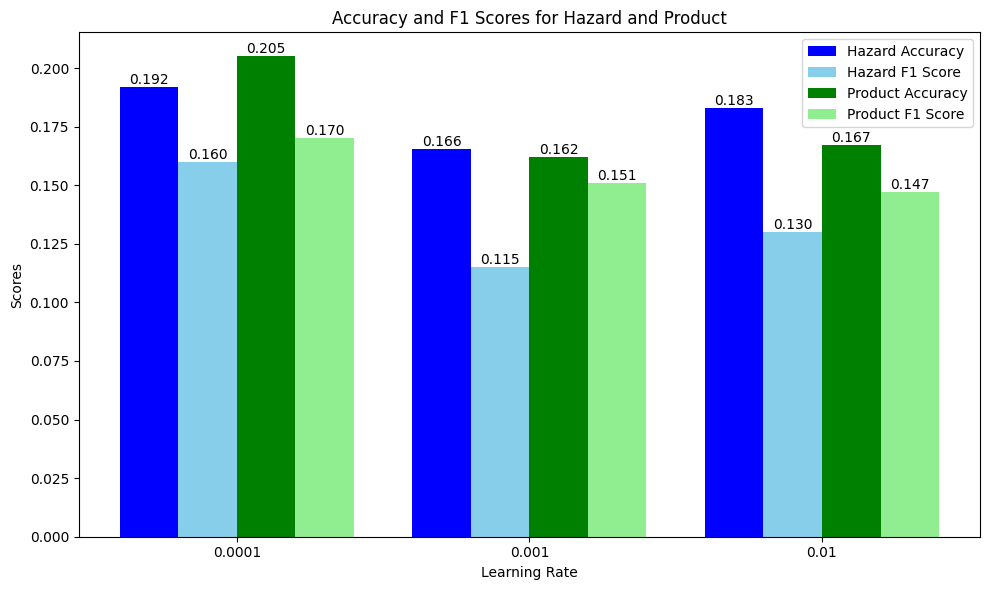

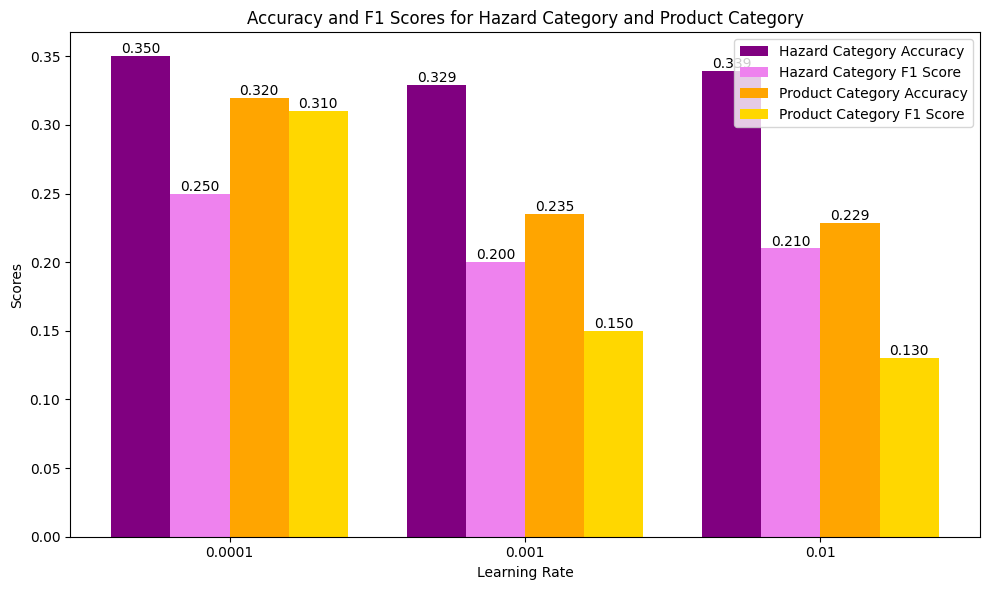

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
learning_rates = ['0.0001', '0.001', '0.01']

# Data for Hazard and Product
hazard_accuracy = [0.192, 0.16552, 0.183]
hazard_f1 = [0.16, 0.115, 0.13]
product_accuracy = [0.205, 0.162, 0.167]
product_f1 = [0.17, 0.151, 0.147]

# Data for Hazard Category and Product Category
hazard_category_accuracy = [0.35, 0.329, 0.339]
hazard_category_f1 = [0.25, 0.20, 0.21]
product_category_accuracy = [0.32, 0.2352, 0.2289]
product_category_f1 = [0.31, 0.15, 0.13]


# Function to add data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom'
        )

# Bar chart for Hazard and Product
x = np.arange(len(learning_rates))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, hazard_accuracy, width, label='Hazard Accuracy', color='blue')
bars2 = ax.bar(x, hazard_f1, width, label='Hazard F1 Score', color='skyblue')
bars3 = ax.bar(x + width, product_accuracy, width, label='Product Accuracy', color='green')
bars4 = ax.bar(x + 2 * width, product_f1, width, label='Product F1 Score', color='lightgreen')

# Add labels and legend
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Scores for Hazard and Product')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(learning_rates)
ax.legend()
plt.tight_layout()
plt.show()

# Bar chart for Hazard Category and Product Category
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, hazard_category_accuracy, width, label='Hazard Category Accuracy', color='purple')
bars2 = ax.bar(x, hazard_category_f1, width, label='Hazard Category F1 Score', color='violet')
bars3 = ax.bar(x + width, product_category_accuracy, width, label='Product Category Accuracy', color='orange')
bars4 = ax.bar(x + 2 * width, product_category_f1, width, label='Product Category F1 Score', color='gold')

# Add labels and legend
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Scores for Hazard Category and Product Category')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(learning_rates)
ax.legend()
plt.tight_layout()
plt.show()